Visit original tutorial page: https://morvanzhou.github.io/tutorials/

Youtube Channel: https://www.youtube.com/user/MorvanZhou

Dependencies:

- torch: 0.4
- torchvision
- matplotlib
- numpy

In [1]:
import os

import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

torch.manual_seed(1)   # reproducible

# Hyper parameters
EPOCH = 20
BATCH_SIZE=  64
LR = 0.005
DOWNLOAD_MNIST= False
N_TEST_IMG = 5


torch.Size([60000, 28, 28])
torch.Size([60000])


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


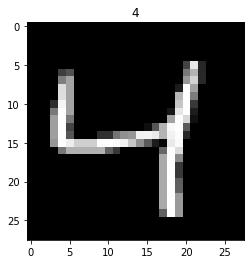

In [2]:
# Mnist digits dataset
if not(os.path.exists('./mnist/')) or not os.listdir('./mnist/'):
    # not mnist dir or mnist is empty dir
    DOWNLOAD_MNIST = True
    
train_data = torchvision.datasets.MNIST(
    root = './mnist/', 
    train=True,                                  # this is training data
    transform=torchvision.transforms.ToTensor(), # Converts a PIL.Image or numpy.ndarray to
                        # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,
)

# plot one example
print(train_data.train_data.size())    # (60000, 28, 28)
print(train_data.train_labels.size())  # (60000)
plt.imshow(train_data.train_data[2].data.numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[2])
plt.show()

train_loader = Data.DataLoader(
    dataset=train_data, 
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64,12),
            nn.Tanh(),
            nn.Linear(12,3), #  compress to 3 features which can be visualized in plt
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.Tanh(),
            nn.Linear(12,64),
            nn.Tanh(),
            nn.Linear(64,128),
            nn.Tanh(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(), # compress to a range (0,1)
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [ ]:
autoencoder = AutoEncoder()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr = LR)
loss_func = nn.MSELoss()

# initialize figure
f, a = plt.subplots(2, N_TEST_IMG, figsize=(5,2))
plt.ion() # continuously plot

f.canvas.draw()
# original data (first row) for viewing
view_data = train_data.train_data[:N_TEST_IMG].view(-1, 28,28).type(torch.FloatTensor)/255.0
for i in range(N_TEST_IMG):
    a[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray')
    a[0][i].set_xticks(())
    a[0][i].set_yticks(())

for epoch in range(EPOCH):
    for step, (x, b_label) in enumerate(train_loader):
        b_x = x.view(-1, 28,28)   # batch x, shape (batch, 28*28)
        b_y = x.view(-1, 28,28)   # batch x, shape (batch, 28*28)
        
        encoded, decoded = autoencoder(b_x.view(-1, 28*28))
        
        loss = loss_func(decoded, b_y.view(-1, 28*28)) # mean square error - MSELoss
        optimizer.zero_grad()          # clear gradients for this training step
        loss.backward()                # backpropagation, calculate gradients
        optimizer.step()               # apply the gradients from above line
        
        if step%100 == 0:
            print('Epoch: %4.0i' % epoch, '| train loss: %6.4f' % loss.data.numpy())
            
            # plotting decoded image (second row)
            _, decoded_data = autoencoder(view_data.view(-1, 28*28))
            for i in range (N_TEST_IMG):
                a[1][i].clear()
                a[1][i].imshow(np.reshape(decoded_data.data.numpy()[i],(28,28)), cmap='gray' )
                a[1][i].set_xticks(()); a[1][i].set_yticks(())
            f.canvas.draw(); # plt.pause(0.05)
plt.ioff()
# plt.show()
view_data = train_data.train_data[:200].view(-1, 28*28).type(torch.FloatTensor)/255.0
encoder_data, _ = autoencoder(view_data)

fig = plt.figure(2); ax = Axes3D(fig)
X,Y,Z=encoder_data.data[:,0].numpy(), encoder_data.data[:,1].numpy(), encoder_data.data[:,2].numpy()
values = train_data.train_labels[:200].numpy()

for x, y, z, s in zip (X, Y, Z, values):
    c=cm.rainbow(int(255*s/9)); ax.text(x, y, z, s, backgroundcolor=c)
ax.set_xlim(X.min(), X.max()); ax.set_ylim(Y.min(), Y.max()); ax.set_zlim(Z.min(), Z.max())

plt.show()

Epoch:    0 | train loss: 0.2301
Epoch:    0 | train loss: 0.0702
Epoch:    0 | train loss: 0.0612
Epoch:    0 | train loss: 0.0572
Epoch:    0 | train loss: 0.0587
Epoch:    0 | train loss: 0.0522
Epoch:    0 | train loss: 0.0511
Epoch:    0 | train loss: 0.0499
Epoch:    0 | train loss: 0.0502
Epoch:    0 | train loss: 0.0443
Epoch:    1 | train loss: 0.0478
Epoch:    1 | train loss: 0.0455
Epoch:    1 | train loss: 0.0442
Epoch:    1 | train loss: 0.0421
Epoch:    1 | train loss: 0.0450
Epoch:    1 | train loss: 0.0427
Epoch:    1 | train loss: 0.0433
Epoch:    1 | train loss: 0.0445
Epoch:    1 | train loss: 0.0436
Epoch:    1 | train loss: 0.0452
Epoch:    2 | train loss: 0.0422
Epoch:    2 | train loss: 0.0424
Epoch:    2 | train loss: 0.0406
Epoch:    2 | train loss: 0.0417
Epoch:    2 | train loss: 0.0449
Epoch:    2 | train loss: 0.0410
Epoch:    2 | train loss: 0.0429
Epoch:    2 | train loss: 0.0428
Epoch:    2 | train loss: 0.0440
Epoch:    2 | train loss: 0.0400
Epoch:    

In [26]:
for i in range (N_TEST_IMG):
    a[1][i].clear()
    a[1][i].imshow(np.reshape(decoded_data.zero_().data.numpy()[i],(28,28)), cmap='gray' )
    a[1][i].set_xticks(()); a[1][i].set_yticks(())
f.canvas.draw();